# Implementation of face recognition using neural net 

In [85]:
%matplotlib inline

In [86]:
import cv2
import numpy as np
import os
from skimage import io
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report,accuracy_score
from sklearn.neural_network import MLPClassifier


In [87]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import metrics

#### Listing the path of all the images

In [88]:
DatasetPath = []
for i in os.listdir("yalefaces"):
    DatasetPath.append(os.path.join("yalefaces", i))

#### Reading each image and assigning respective labels

In [89]:
imageData = []
imageLabels = []

In [90]:
for i in DatasetPath:
    imgRead = io.imread(i,as_grey=True)
    imageData.append(imgRead)
    
    labelRead = int(os.path.split(i)[1].split(".")[0].replace("subject", "")) - 1
    imageLabels.append(labelRead)

#### Preprocessing: Face Detection using OpenCV and cropping the image to a size of 150 * 150

In [91]:
faceDetectClassifier = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
imageDataFin = []
for i in imageData:
    facePoints = faceDetectClassifier.detectMultiScale(i)
    x,y = facePoints[0][:2]
    cropped = i[y: y + 150, x: x + 150]
    imageDataFin.append(cropped)

In [92]:
c = np.array(imageDataFin)

In [93]:
c.shape

(165, 150, 150)

#### Splitting Dataset into train and test

In [94]:
X_train, X_test, y_train, y_test = train_test_split(np.array(imageDataFin),np.array(imageLabels), train_size=0.7, random_state = 20)

In [95]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [96]:
X_train.shape

(115, 150, 150)

In [97]:
X_test.shape

(50, 150, 150)

In [98]:
nb_classes = 15
y_train = np.array(y_train) 
y_test = np.array(y_test) 

In [99]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

#### Converting each 2d image into 1D vector

In [100]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalize the data
X_train /= 255
X_test /= 255

#### Preprocessing -PCA

Plot of amount of variance explained vs pcs


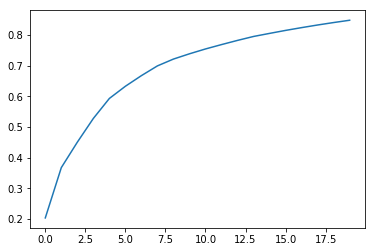

('Training PCA shape', (115, 20))
('Test PCA shape', (50, 20))
Eigen Faces


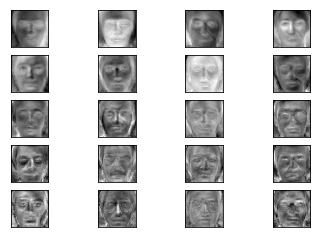

In [101]:
computed_pca = PCA(n_components = 20,whiten=True).fit(X_train)
XTr_pca = computed_pca.transform(X_train)

print("Plot of amount of variance explained vs pcs")
plt.plot(range(len(computed_pca.explained_variance_)),np.cumsum(computed_pca.explained_variance_ratio_))
plt.show()

XTs_pca = computed_pca.transform(X_test)
print("Training PCA shape",XTr_pca.shape)
print("Test PCA shape",XTs_pca.shape)


def plot_eigenfaces(images, h, w, rows=5, cols=4):
    plt.figure()
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
plot_eigenfaces(computed_pca.components_,150,150)
print("Eigen Faces")

In [102]:
print("Original Training matrix shape", X_train.shape)
print("Original Testing matrix shape", X_test.shape)

('Original Training matrix shape', (115, 22500))
('Original Testing matrix shape', (50, 22500))


In [103]:
print("Fitting the classifier to the training set")
clf = MLPClassifier(hidden_layer_sizes=(1024,), batch_size=64, verbose=True, early_stopping=True).fit(XTr_pca, y_train)

Fitting the classifier to the training set
Iteration 1, loss = 2.72169800
Validation score: 0.250000
Iteration 2, loss = 2.45276942
Validation score: 0.583333
Iteration 3, loss = 2.21445885
Validation score: 0.833333
Iteration 4, loss = 1.98743373
Validation score: 0.916667
Iteration 5, loss = 1.76776871
Validation score: 0.916667
Iteration 6, loss = 1.56434503
Validation score: 0.916667
Iteration 7, loss = 1.37756922
Validation score: 0.916667
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


In [104]:
y_pred = clf.predict(XTs_pca)
#print(y_pred,y_test)
print(classification_report(y_test, y_pred))
print("Accuracy: ",accuracy_score(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.67      1.00      0.80         2
          1       1.00      0.40      0.57         5
          2       0.50      1.00      0.67         2
          3       0.60      1.00      0.75         3
          4       1.00      0.80      0.89         5
          5       1.00      1.00      1.00         5
          6       1.00      1.00      1.00         3
          7       1.00      1.00      1.00         3
          8       1.00      0.50      0.67         4
          9       1.00      1.00      1.00         3
         10       0.80      1.00      0.89         4
         11       0.60      1.00      0.75         3
         12       1.00      1.00      1.00         2
         13       0.67      0.50      0.57         4
         14       1.00      0.50      0.67         2

avg / total       0.88      0.82      0.81        50

('Accuracy: ', 0.81999999999999995)


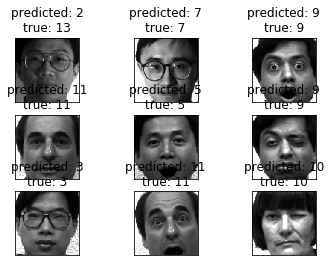

In [105]:
# Visualization
def plot_gallery(images, titles, h, w, rows=3, cols=3):
    plt.figure()
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())
 
def titles(y_pred, y_test):
    for i in range(y_pred.shape[0]):
        pred_name = y_pred[i]
        true_name = y_test[i]
        yield 'predicted: {0}\ntrue: {1}'.format(pred_name, true_name)
 
prediction_titles = list(titles(y_pred, y_test))
plot_gallery(X_test, prediction_titles, 150, 150)


#### Defining the model

In [106]:
model = Sequential()
model.add(Dense(512,input_shape=(XTr_pca.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [107]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               10752     
_________________________________________________________________
activation_7 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_8 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 15)                7695      
__________

In [108]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=[metrics.mae,metrics.categorical_accuracy])

#### Training

In [109]:
model.fit(XTr_pca, Y_train, batch_size=64, epochs=50, verbose=1, validation_data=(XTs_pca, Y_test))

Train on 115 samples, validate on 50 samples
Epoch 1/50
115/115 [==============================] - 0s 4ms/step - loss: 2.6741 - mean_absolute_error: 0.1238 - categorical_accuracy: 0.1565 - val_loss: 2.4677 - val_mean_absolute_error: 0.1218 - val_categorical_accuracy: 0.5400
Epoch 2/50
115/115 [==============================] - 0s 202us/step - loss: 2.3206 - mean_absolute_error: 0.1195 - categorical_accuracy: 0.6087 - val_loss: 2.2317 - val_mean_absolute_error: 0.1184 - val_categorical_accuracy: 0.7000
Epoch 3/50
115/115 [==============================] - 0s 190us/step - loss: 1.9277 - mean_absolute_error: 0.1124 - categorical_accuracy: 0.8087 - val_loss: 1.9980 - val_mean_absolute_error: 0.1138 - val_categorical_accuracy: 0.7600
Epoch 4/50
115/115 [==============================] - 0s 181us/step - loss: 1.6127 - mean_absolute_error: 0.1042 - categorical_accuracy: 0.9217 - val_loss: 1.7571 - val_mean_absolute_error: 0.1073 - val_categorical_accuracy: 0.8000
Epoch 5/50
115/115 [=========

Epoch 36/50
115/115 [==============================] - 0s 235us/step - loss: 0.0049 - mean_absolute_error: 6.5306e-04 - categorical_accuracy: 1.0000 - val_loss: 0.4972 - val_mean_absolute_error: 0.0260 - val_categorical_accuracy: 0.8400
Epoch 37/50
115/115 [==============================] - 0s 188us/step - loss: 0.0049 - mean_absolute_error: 6.4682e-04 - categorical_accuracy: 1.0000 - val_loss: 0.4973 - val_mean_absolute_error: 0.0260 - val_categorical_accuracy: 0.8400
Epoch 38/50
115/115 [==============================] - 0s 165us/step - loss: 0.0046 - mean_absolute_error: 6.0270e-04 - categorical_accuracy: 1.0000 - val_loss: 0.4975 - val_mean_absolute_error: 0.0260 - val_categorical_accuracy: 0.8400
Epoch 39/50
115/115 [==============================] - 0s 176us/step - loss: 0.0051 - mean_absolute_error: 6.6556e-04 - categorical_accuracy: 1.0000 - val_loss: 0.4962 - val_mean_absolute_error: 0.0259 - val_categorical_accuracy: 0.8400
Epoch 40/50
115/115 [==============================]

#### Evaluating the performance

In [110]:
loss,mean_absolute_error,accuracy = model.evaluate(XTs_pca,Y_test, verbose=0)

In [111]:
print("Loss:", loss)
print("Categorical Accuracy: ", accuracy)
print("Mean absolute error: ", mean_absolute_error)

('Loss:', 0.49468110799789428)
('Categorical Accuracy: ', 0.86000000238418584)
('Mean absolute error: ', 0.02528877690434456)


In [112]:
predicted_classes = model.predict_classes(XTs_pca)

In [113]:
correct_classified_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_classified_indices = np.nonzero(predicted_classes != y_test)[0]

In [114]:
correct_classified_indices

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18,
       19, 21, 22, 23, 24, 26, 27, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39,
       40, 42, 43, 44, 45, 46, 47, 48, 49])

In [115]:
incorrect_classified_indices

array([ 0, 13, 20, 25, 28, 32, 41])

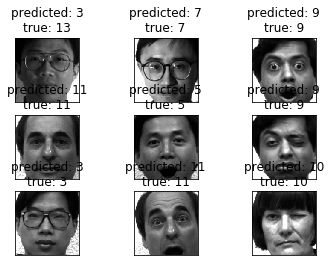

In [116]:
prediction_titles = list(titles(predicted_classes, y_test))
plot_gallery(X_test, prediction_titles, 150, 150)

